In [1]:
import torch
import torch.utils.data
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from hybrid_drop import *
import numpy as np
import pickle 
import sys
import os 

In [2]:
train_loader = torch.utils.data.DataLoader(
                        torchvision.datasets.MNIST('/files/', train=True,download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                        batch_size=3, shuffle=True,pin_memory=False,num_workers=0)


In [3]:
data, target = next(iter(train_loader))

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'other'

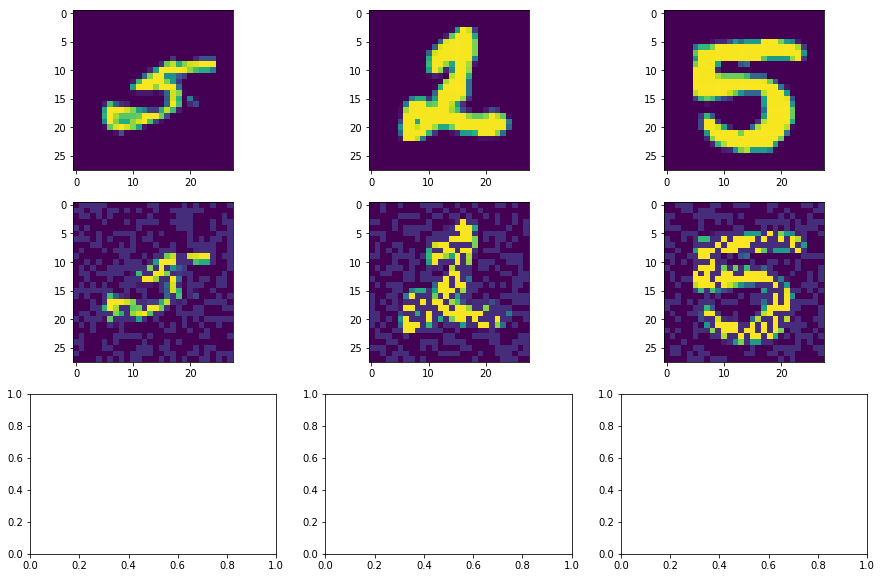

In [4]:
transform = HybridDropout_Normal(.3)
elems = len(data)
fig, axes = plt.subplots(3,elems,figsize=(15,10))
for i in range(len(data)*3):
    axis = axes[i//elems][i%elems]
    if i<len(data):
        axis.imshow(data[i%elems][0])
    elif i<2*len(data):
        axis.imshow(nn.Dropout(.4)(data)[i%elems][0])
    else:
        axis.imshow(transform(data)[i%elems][0])


In [ ]:
def bootstrap_func(data,func,n_samples=1000):
    """
    Performs bootstrap to compute arbitrary statistic
    -data data to bootstrap from
    -func function to apply to calculate statistic (e.g. mean for calculating means)
    -n_samples number of bootstrap samples to perform
    """
    result = []
    for _ in range(n_samples):
        #resample and compute statistic
        param = func(np.random.choice(data,size=len(data))) 
        #store statistic
        result.append(param)
    return np.array(result)

In [ ]:
folder = 'point5_longer/'
data_normal = []
data_hybrid_normal = []
for file in os.listdir('/data/'+folder):
    if file[:6]=='normal':
        with open('/data/'+folder+file,'rb') as f:
            data_normal.append(pickle.load(f))
    if file[:13]=='hybrid_normal':
        with open('/data/'+folder+file,'rb') as f:
            data_hybrid_normal.append(pickle.load(f))



In [ ]:
train_losses_normal = np.array([x[0] for x in data_normal])
train_losses_hybrid_normal = np.array([x[0] for x in data_hybrid_normal])
test_losses_normal = np.array([x[3] for x in data_normal])
test_losses_hybrid_normal = np.array([x[3] for x in data_hybrid_normal])
test_correct_normal = np.array([x[-1] for x in data_normal])
test_correct_hybrid_normal = np.array([x[-1] for x in data_hybrid_normal])

train_counter = data_hybrid_normal[0][2]
test_counter = data_hybrid_normal[0][4]

In [ ]:
fig, axes = plt.subplots(1,2,figsize = (15,5))
ax1,ax2 = axes

ax1.plot(train_counter,
         np.convolve(train_losses_normal[0],np.ones((200,))/200,mode='same',),
         color='steelblue')
ax1.plot(test_counter,test_losses_normal[0],
         color='firebrick')
ax1.legend(['Train Loss', 'Test Loss'], loc='upper right')
ax1.set_ylim([0,0.1])
ax1.set_title('Ordinary Dropout With .2 rate',fontdict={'fontsize':14})
ax1.set_xlabel('# of training examples seen')
ax1.set_ylabel('Negative log likelihood loss')


ax2.plot(train_counter,
         np.convolve(train_losses_hybrid_normal[0],np.ones((200,))/200,mode='same',),
         color='steelblue')
ax2.plot(test_counter,test_losses_hybrid_normal[0],
         color='firebrick')
ax2.legend(['Train Loss', 'Test Loss'], loc='upper right')
ax2.set_ylim([0,.3])
ax2.set_title('Hybrid Dropout With .2 rate',fontdict={'fontsize':14})
ax2.set_xlabel('# of training examples seen')
ax2.set_ylabel('Negative log likelihood loss')
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2,figsize = (15,5))
ax1,ax2 = axes
ax1.plot(test_counter,
         np.mean(test_losses_normal,0),
         color='steelblue')
ax1.plot(test_counter,
         np.mean(test_losses_hybrid_normal,0),
         color='firebrick')
ax1.legend(['Ordinary Dropout', 'Hybrid Dropout'], loc='upper right')
ax1.set_title('Test Losses With .2 dropout rate',fontdict={'fontsize':14})
ax1.set_xlabel('# of training examples seen')
ax1.set_ylim([0,.1])
ax1.set_ylabel('Negative log likelihood loss')

differences = [bootstrap_func(test_losses_hybrid_normal[:,i],np.mean,100)-bootstrap_func(test_losses_normal[:,i],np.mean,100) for i in range(len(test_correct_normal[0]))]
ax2.plot(test_counter,
         np.mean(differences,axis=1),
         color='firebrick')
lower,upper = np.percentile(differences,[2.5,97.5],axis=1)
ax2.fill_between(test_counter, lower, upper, facecolor='blue', alpha=0.2)

ax2.legend(['Mean Gap', '95% Confidence Bound'], loc='upper right')
ax2.hlines(0,0,test_counter[-1])
ax2.set_ylim([-.02,.02])
ax2.set_title('Test Loss Gap between Hybrid and \n Ordinary Dropout With .2 dropout rate',fontdict={'fontsize':14})
ax2.set_xlabel('# of training examples seen')
ax2.set_ylabel('Negative log likelihood loss gap')
plt.show()


In [ ]:
fig, axes = plt.subplots(1,2,figsize = (15,5))
ax1,ax2 = axes
ax1.plot(test_counter,
         10000-np.mean(test_correct_normal,0),
         color='steelblue')
ax1.plot(test_counter,
         10000-np.mean(test_correct_hybrid_normal,0),
         color='firebrick')
ax1.legend(['Ordinary Dropout', 'Hybrid Dropout'], loc='upper right')
ax1.set_title('Test Misclassification With .2 dropout rate',fontdict={'fontsize':14})
ax1.set_xlabel('# of training examples seen')
ax1.set_ylim([0,100])
ax1.set_ylabel('Number of incorrectly classified samples')

differences = [bootstrap_func(test_correct_hybrid_normal[:,i],np.mean,100)-bootstrap_func(test_correct_normal[:,i],np.mean,100) for i in range(len(test_correct_normal[0]))]
ax2.plot(test_counter,
         np.mean(differences,axis=1),
         color='firebrick')
lower,upper = np.percentile(differences,[2.5,97.5],axis=1)
ax2.fill_between(test_counter, lower, upper, facecolor='blue', alpha=0.2)

ax2.legend(['Mean Gap', '95% Confidence Bound'], loc='upper right')
ax2.hlines(0,0,test_counter[-1])
ax2.set_ylim([-20,20])
ax2.set_title('Test Misclassification Gap between Hybrid and \n Ordinary Dropout With .2 dropout rate',fontdict={'fontsize':14})
ax2.set_xlabel('# of training examples seen')
ax2.set_ylabel('Correct samples gap')
plt.show()
